In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(20000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = i / 255
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((20000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f2fee193d38894f6.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-6278461a38d48701.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-0e6cb3bfb465d937.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-0cc4af6669d92b8d.arrow


((20000, 3, 64, 64), 0.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(312, torch.Size([64, 3, 64, 64]))

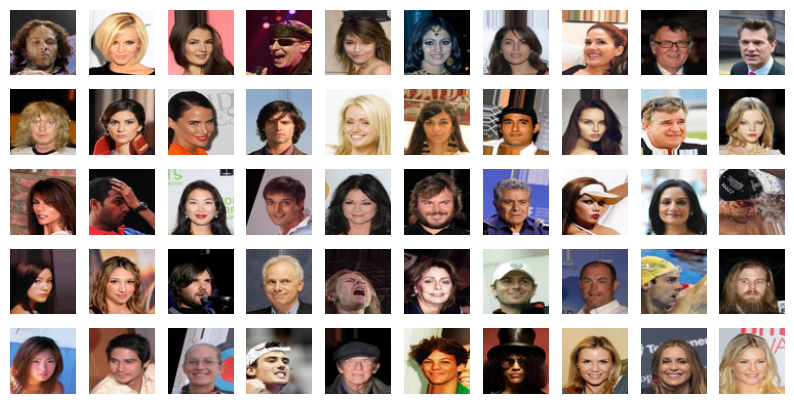

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
def schedule(time, method='offset_cosine'):
    if method == 'linear':
        t = 1 - (1e-4 + time * (0.02 - 1e-4))

        #累乘
        #cumprod = [1]
        #for i in t:
        #    cumprod.append(cumprod[-1] * i)
        #t = torch.FloatTensor(cumprod[1:])

        #等价
        t = torch.cumprod(t, dim=0)

        return (1 - t).sqrt(), t.sqrt()

    if method == 'cosine':
        #1.5707963267948966 = pi/2
        t = time * 1.5707963267948966
        return t.sin(), t.cos()

    if method == 'offset_cosine':
        #0.3175604292915215 = acos(0.95)
        #1.2332345639299847 = acos(0.02) - acos(0.95)
        t = 0.3175604292915215 + time * 1.2332345639299847

        return t.sin(), t.cos()


time = torch.arange(20) / 20
print('linear=', schedule(time, 'linear'))
print('cosine=', schedule(time, 'cosine'))
print('offset_cosine=', schedule(time, 'offset_cosine'))

linear= (tensor([0.0100, 0.0346, 0.0573, 0.0797, 0.1020, 0.1242, 0.1463, 0.1683, 0.1901,
        0.2119, 0.2334, 0.2548, 0.2760, 0.2970, 0.3178, 0.3384, 0.3588, 0.3789,
        0.3987, 0.4183]), tensor([0.9999, 0.9994, 0.9984, 0.9968, 0.9948, 0.9923, 0.9892, 0.9857, 0.9818,
        0.9773, 0.9724, 0.9670, 0.9612, 0.9549, 0.9481, 0.9410, 0.9334, 0.9255,
        0.9171, 0.9083]))
cosine= (tensor([0.0000, 0.0785, 0.1564, 0.2334, 0.3090, 0.3827, 0.4540, 0.5225, 0.5878,
        0.6494, 0.7071, 0.7604, 0.8090, 0.8526, 0.8910, 0.9239, 0.9511, 0.9724,
        0.9877, 0.9969]), tensor([1.0000, 0.9969, 0.9877, 0.9724, 0.9511, 0.9239, 0.8910, 0.8526, 0.8090,
        0.7604, 0.7071, 0.6494, 0.5878, 0.5225, 0.4540, 0.3827, 0.3090, 0.2334,
        0.1564, 0.0785]))
offset_cosine= (tensor([0.3122, 0.3702, 0.4267, 0.4817, 0.5347, 0.5858, 0.6346, 0.6810, 0.7249,
        0.7659, 0.8041, 0.8392, 0.8711, 0.8997, 0.9249, 0.9466, 0.9647, 0.9791,
        0.9897, 0.9967]), tensor([0.9500, 0.9290, 0.9044, 0.87

In [5]:
class Combine(torch.nn.Module):

    def __init__(self):
        super().__init__()

        #6.907755278982137 = log(1000)
        t = torch.linspace(0.0, 6.907755278982137, 16).exp()
        t *= 2
        #3.141592653589793 = pi
        t *= 3.141592653589793
        self.register_buffer('t', t)

        self.upsample = torch.nn.UpsamplingNearest2d(size=(64, 64))

        self.cnn = torch.nn.Conv2d(3, 32, kernel_size=1, stride=1, padding=0)

    def get_var(self, var):
        #[b, 1] -> [b, 16]
        var = self.t * var

        #[b, 16+16] -> [b, 32]
        var = torch.cat((var.sin(), var.cos()), dim=1)

        #[b, 32] -> [b, 32, 1, 1]
        var = var.unsqueeze(dim=-1).unsqueeze(dim=-1)

        #[b, 32, 1, 1] -> [b, 32, 64, 64]
        var = self.upsample(var)

        return var

    def get_image(self, image):
        #[b, 3, 64, 64] -> [b, 32, 64, 64]
        image = self.cnn(image)

        return image

    def forward(self, image, var):
        #image -> [b, 3, 64, 64]
        #var -> [b, 1, 1, 1]

        #[b, 1, 1, 1] -> [b, 1]
        var = var.squeeze(dim=-1).squeeze(dim=-1)

        #[b, 1] -> [b, 32, 64, 64]
        var = self.get_var(var)

        #[b, 3, 64, 64] -> [b, 32, 64, 64]
        image = self.get_image(image)

        #[b, 32+32, 64, 64] -> [b, 64, 64, 64]
        combine = torch.cat((image, var), dim=1)

        return combine


Combine()(torch.randn(2, 3, 64, 64), torch.randn(2, 1, 1, 1)).shape

torch.Size([2, 64, 64, 64])

In [6]:
class Residual(torch.nn.Module):

    def __init__(self, channel_in, channel_out):
        super().__init__()

        self.cnn = torch.nn.Conv2d(channel_in,
                                   channel_out,
                                   kernel_size=1,
                                   stride=1,
                                   padding=0)

        self.s = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channel_in),
            torch.nn.Conv2d(channel_in,
                            channel_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.SiLU(),
            torch.nn.Conv2d(channel_out,
                            channel_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
        )

    def forward(self, x):
        return self.cnn(x) + self.s(x)


Residual(3, 6)(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 6, 64, 64])

In [7]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.down = torch.nn.ModuleList([
            Residual(64, 32),
            Residual(32, 32),
            torch.nn.AvgPool2d(2),
            Residual(32, 64),
            Residual(64, 64),
            torch.nn.AvgPool2d(2),
            Residual(64, 96),
            Residual(96, 96),
            torch.nn.AvgPool2d(2),
        ])

        self.middle = torch.nn.ModuleList([
            Residual(96, 128),
            Residual(128, 128),
        ])

        self.up = torch.nn.ModuleList([
            torch.nn.UpsamplingBilinear2d(scale_factor=2),
            Residual(224, 96),
            Residual(192, 96),
            torch.nn.UpsamplingBilinear2d(scale_factor=2),
            Residual(160, 64),
            Residual(128, 64),
            torch.nn.UpsamplingBilinear2d(scale_factor=2),
            Residual(96, 32),
            Residual(64, 32),
        ])

        self.out = torch.nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, image):
        #image -> [b, 64, 64, 64]

        #[b, 32, 64, 64]
        #[b, 32, 64, 64]
        #[b, 64, 32, 32]
        #[b, 64, 32, 32]
        #[b, 96, 16, 16]
        #[b, 96, 16, 16]
        out = []
        for i in self.down:
            image = i(image)
            if type(i) == Residual:
                out.append(image)

        #[b, 96, 16, 16] -> [b, 128, 8, 8]
        for i in self.middle:
            image = i(image)

        #[b, 96, 16, 16]
        #[b, 96, 16, 16]
        #[b, 64, 32, 32]
        #[b, 64, 32, 32]
        #[b, 32, 64, 64]
        #[b, 32, 64, 64]
        for i in self.up:
            if type(i) == Residual:
                #[b, 128+96, 16, 16] -> [b, 224, 16, 16]
                #[b, 96+96, 16, 16] -> [b, 192, 16, 16]
                #[b, 96+64, 32, 32] -> [b, 160, 32, 32]
                #[b, 64+64, 32, 32] -> [b, 128, 32, 32]
                #[b, 64+32, 64, 64] -> [b, 96, 64, 64]
                #[b, 32+32, 64, 64] -> [b, 64, 64, 64]
                p = out.pop()
                image = torch.cat((image, p), dim=1)
            image = i(image)

        #[b, 32, 64, 64] -> [b, 3, 64, 64]
        image = self.out(image)

        return image


UNet()(torch.randn(2, 64, 64, 64)).shape

torch.Size([2, 3, 64, 64])

In [8]:
from transformers import PreTrainedModel, PretrainedConfig


class Diffusion(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)

        self.norm = torch.nn.BatchNorm2d(3, affine=False)
        self.unet = UNet()
        self.combine = Combine()

    def forward(self, image):
        #image -> [b, 3, 64, 64]
        b = image.shape[0]

        #对图像正则化处理
        image = self.norm(image)

        #随机噪声
        noise = torch.randn(b, 3, 64, 64, device=image.device)

        #随机系数
        #[b, 1, 1, 1],[b, 1, 1, 1]
        noise_r, image_r = schedule(torch.rand(b, 1, 1, 1,
                                               device=image.device))

        #合并图像和噪声
        #[b, 3, 64, 64]
        image = image * image_r + noise * noise_r

        #合并噪声图和噪声系数
        #[b, 64, 64, 64]
        combine = self.combine(image, noise_r**2)

        #从噪声图中预测出噪声
        pred_noise = self.unet(combine)

        return noise, pred_noise


diffusion = Diffusion(PretrainedConfig())

_ = diffusion(torch.randn(2, 3, 64, 64))

_[0].shape, _[1].shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 3, 64, 64]))

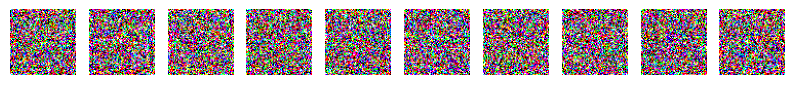

In [9]:
def generate(n, device):
    #从随机噪声开始生成
    image = torch.randn(n, 3, 64, 64, device=device)

    #生成20个step
    for i in range(20):
        time = torch.full(size=(n, 1, 1, 1),
                          fill_value=(20 - i) / 20,
                          dtype=torch.float32,
                          device=device)

        #随机系数
        noise_r, image_r = schedule(time)

        #合并噪声图和噪声系数
        #[b, 64, 64, 64]
        combine = diffusion.combine(image, noise_r**2)

        #从噪声图中预测出噪声
        pred_noise = diffusion.unet(combine)

        #根据预测的噪声还原图像
        pred_image = (image - noise_r * pred_noise) / image_r

        #再次计算随机系数
        time = time - (1 / 20)
        noise_r, image_r = schedule(time)

        #重新向图像中添加噪声,以进行下一个step的计算
        image = image_r * pred_image + noise_r * pred_noise

    #根据正则化数据反正则化图像
    mean = diffusion.norm.running_mean.reshape(1, 3, 1, 1)
    std = (diffusion.norm.running_var**0.5).reshape(1, 3, 1, 1)

    pred_image = mean + pred_image * std
    pred_image = pred_image.clip(0.0, 1.0)

    return pred_image


show(generate(10, 'cpu'))

0 0.16872939467430115


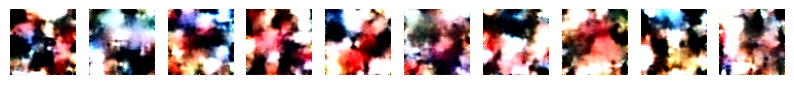

100 0.11785537004470825


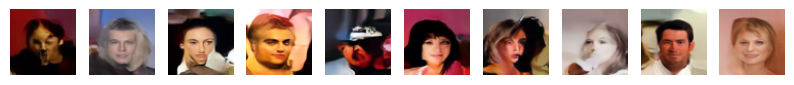

200 0.10527437925338745


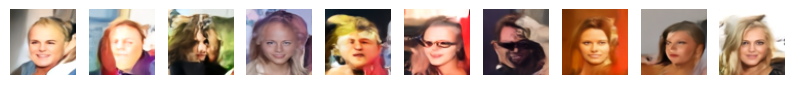

300 0.10829593986272812


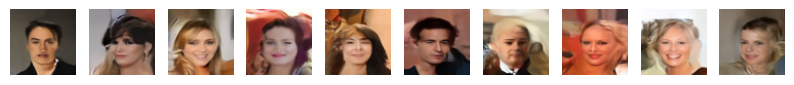

400 0.11608608067035675


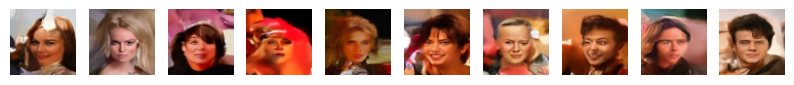

500 0.10829814523458481


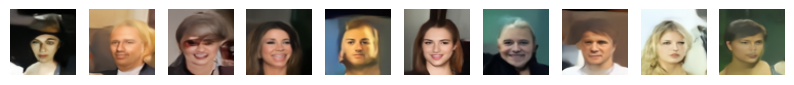

600 0.10430701076984406


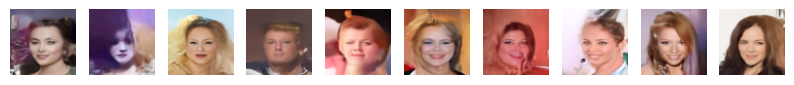

700 0.10065597295761108


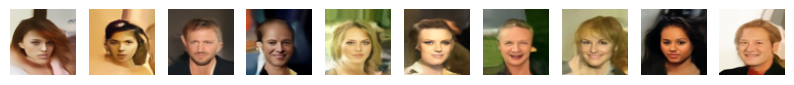

800 0.1019054651260376


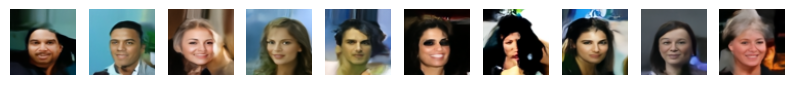

900 0.09691470861434937


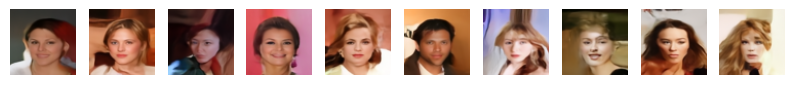

1000 0.10256151854991913


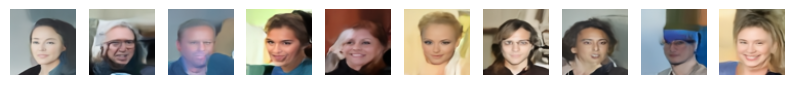

1100 0.10637321323156357


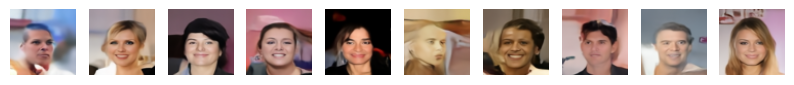

1200 0.11518530547618866


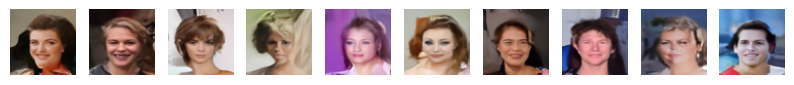

1300 0.10632959008216858


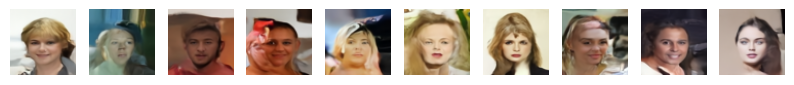

1400 0.11090730130672455


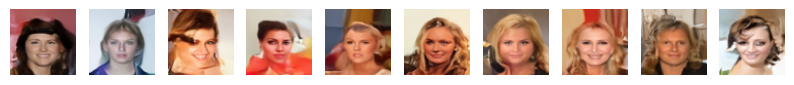

1500 0.09999643266201019


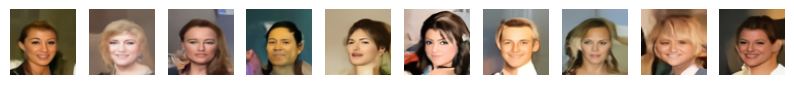

1600 0.1030057892203331


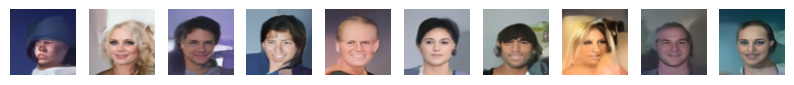

1700 0.10572272539138794


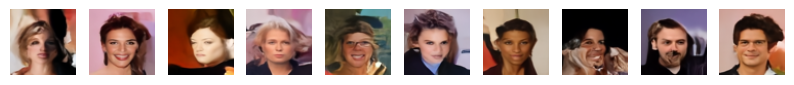

1800 0.09865148365497589


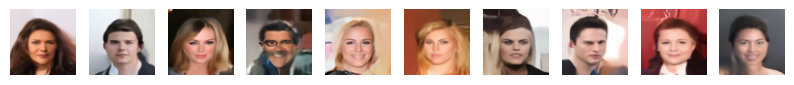

1900 0.09499632567167282


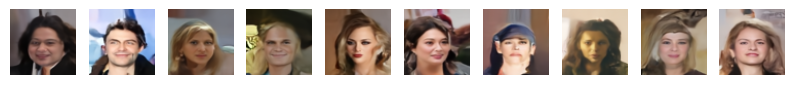

In [10]:
def train():
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.AdamW(diffusion.parameters(),
                                  lr=2e-4,
                                  weight_decay=1e-4)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    diffusion.to(device)
    diffusion.train()

    for epoch in range(2000):
        for i, data in enumerate(loader):
            noise, pred_noise = diffusion(data.to(device))

            loss = criterion(noise, pred_noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 100 == 0:
            print(epoch, loss.item())
            diffusion.eval()
            show(generate(10, device))
            diffusion.train()


local_training = True

if local_training:
    train()

In [11]:
if local_training:
    #保存训练好的模型到hub
    diffusion.to('cpu').push_to_hub(
        repo_id='lansinuote/gen.9.diffusion',
        use_auth_token=open('/root/hub_token.txt').read().strip())

pytorch_model.bin:   0%|          | 0.00/8.00M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

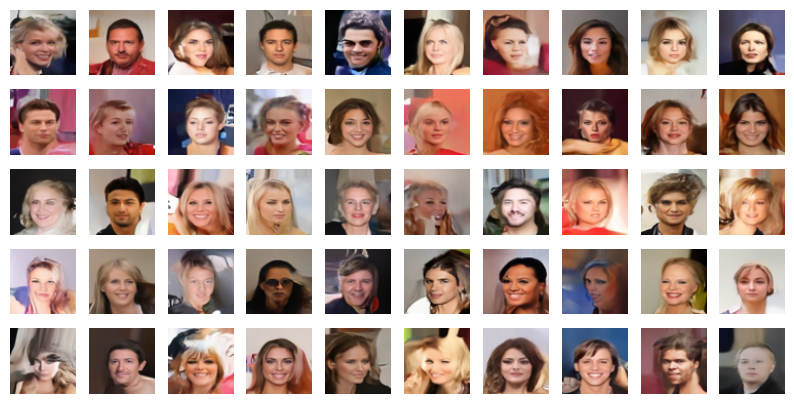

In [12]:
#加载训练好的模型
diffusion = Diffusion.from_pretrained('lansinuote/gen.9.diffusion')

with torch.no_grad():
    show(generate(50, 'cpu'))